In this notebook we try to set up data and models using the jraph library.

### imports and setup

In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from lorenz import lorenzDatasetWrapper
from plotters import plot_data

2023-05-01 15:23:40.549673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import jraph
import jax
import jax.numpy as jnp
import networkx as nx
import haiku as hk


In [43]:
# for training sequence
import functools
import optax
from typing import Any, Callable, Dict, List, Optional, Tuple, Iterable

In [5]:
# # Imports
# %matplotlib inline
# import matplotlib.pyplot as plt
# import jax.tree_util as tree
# import jraph
# import flax
# import pickle
# import numpy as onp


### graph data structures

In [357]:
def lorenz_graph(n_samples=2_000):
    # i'm just going to pull the data out of a lorenz spektral dataset
    # this is computationally inefficient but convenient code-wise so I don't
    # have to rewrite all the normalization functions and stuff

    # only uncomment each line if testing a non-default parameter
    K = 36
    dataset = lorenzDatasetWrapper(
        predict_from="X1X2_window",
        n_samples=n_samples,
        input_steps=1,
        output_delay=0,
        output_steps=0,
        min_buffer=0,
        # rand_buffer=False,
        K=K,
        # F=8,
        # c=10,
        # b=10,
        # h=1,
        # coupled=True,
        # time_resolution=DEFAULT_TIME_RESOLUTION,
        # seed=42,
        init_buffer_steps=100,
        return_buffer=False,
        train_pct=1,
        val_pct=0,
        test_pct=0,
        override=False)
    dataset.normalize()

    # iter over time steps in lorenz data

    graph_tuple_list = []
    # construct a new data dict for each time step
    for g in dataset.train:
        # g.x has shape 36 x 2
        graph_tuple = timestep_to_graphstuple(g.x, K=K)
        graph_tuple_list.append(graph_tuple)

    # convert all data dicts into a single GraphTuple
    # graph_tuple = utils_np.data_dicts_to_graphs_tuple(data_dict_list)

    # return graph_tuple
    return graph_tuple_list


def timestep_to_graphstuple(data, K):
    """ Args:
            data: array of shape (K, num_fts)
            K (int): number of nodes in the Lorenz system
            ft_type (str): either "global" or "nodes", i.e. whether the 
                node-wise features of the Lorenz system should be represented using node features or global features in the GN approach. 
    
    """
    # define edges
    receivers = []
    senders = []
    edge_fts = []

    for i in range(K):
        senders += [i] * 5
        receivers += [i, (i + 1) % K, (i + 2) % K, (i - 1) % K, (i - 2) % K]

        # edge features = length + direction of edge
        edge_fts += [
            [0],  # self edge
            [1],  # receiver is 1 node to the right
            [2],  # receiver is 2 nodes to the right
            [-1],  # receiver is 1 node to the left
            [-2]  # receiver is 2 nodes to the left
        ]

    return jraph.GraphsTuple(
        globals=jnp.array([[1]]),  # placeholder global features for now
        # globals=jnp.array([]),  # no global features for now
        # globals=None,  # no global features for now
        nodes=jnp.array(
            data),  # node features = atmospheric measurements. shape of (K, 2)
        edges=jnp.array(edge_fts, dtype=float),
        receivers=jnp.array(receivers),
        senders=jnp.array(senders),
        n_node=jnp.array([K]),
        n_edge=jnp.array([K * 5]))


In [358]:
def print_graph_fts(graph: jraph.GraphsTuple):
    print(f'Number of nodes: {graph.n_node[0]}')
    print(f'Number of edges: {graph.n_edge[0]}')
    print(f'Node features shape: {graph.nodes.shape}')
    print(f'Edge features shape: {graph.edges.shape}')
    print(f'globals: {graph.globals}')

In [359]:
graph_tuple_list = lorenz_graph(n_samples=200)

done computing adj


In [360]:
print_graph_fts(graph_tuple_list[0])

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
globals: [[1]]


In [317]:
graph_tuple_list[0]

GraphsTuple(nodes=Array([[-1.0068141e-01, -2.5620444e+00],
       [-2.1361177e+00, -1.8751092e-03],
       [-1.1005859e+00, -1.1888039e+00],
       [-9.8726666e-01, -6.8440551e-01],
       [-6.3317990e-01, -7.0255822e-01],
       [-8.3306378e-01, -1.0056221e+00],
       [ 1.1483135e+00, -1.1483214e+00],
       [-1.1944407e+00, -1.0810429e+00],
       [-2.3665106e+00, -2.2060866e+00],
       [-3.1964359e+00,  2.5251386e-01],
       [-3.5159627e-01, -7.8088224e-01],
       [-2.6588878e-01,  1.6795808e+00],
       [-2.2034383e+00, -1.2868527e+00],
       [-2.9422021e+00, -2.2480847e-01],
       [-3.9738032e-01,  1.9159193e-01],
       [ 7.7164894e-01,  1.6113763e+00],
       [-2.5608132e+00, -3.5392358e+00],
       [-2.0062299e+00, -6.9637984e-01],
       [ 2.5362630e+00, -1.8174256e+00],
       [ 7.4520874e-01,  1.9926126e+00],
       [-1.0028402e+00, -1.0969293e-02],
       [ 9.8851234e-01,  1.6902227e+00],
       [ 2.8463137e+00,  2.5636549e+00],
       [-1.1584989e+00, -1.0695308e+00]

#### visualization

visualize graph

In [7]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
    nodes, edges, receivers, senders, _, _, _ = jraph_graph
    nx_graph = nx.DiGraph()
    if nodes is None:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n)
    else:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n, node_feature=nodes[n])
    if edges is None:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]), int(receivers[e]))
    else:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]),
                              int(receivers[e]),
                              edge_feature=edges[e])
    return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
    nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
    pos = nx.circular_layout(nx_graph)
    X1_attr = [nx_graph.nodes[i]['node_feature'][0] for i in nx_graph.nodes]

    nx.draw_networkx(nx_graph,
                     pos=pos,
                     cmap=plt.cm.plasma,
                     node_color=X1_attr,
                     vmin=-12,
                     vmax=12,
                     with_labels=True,
                     node_size=200,
                     font_color='yellow')

    # get colorbar
    ax = plt.gca()
    PCM = ax.get_children()[0]  # this index may vary
    plt.colorbar(PCM, ax=ax)
    plt.title('X1 data for nodes')


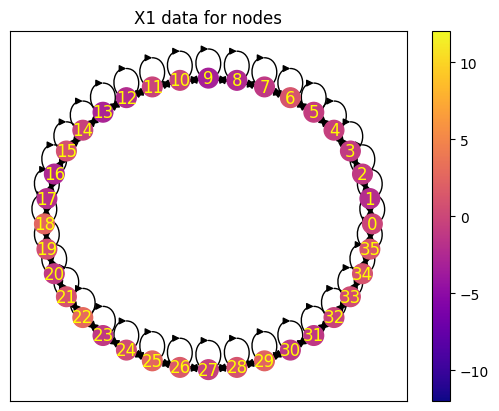

In [133]:
draw_jraph_graph_structure(graph_tuple_list[0])

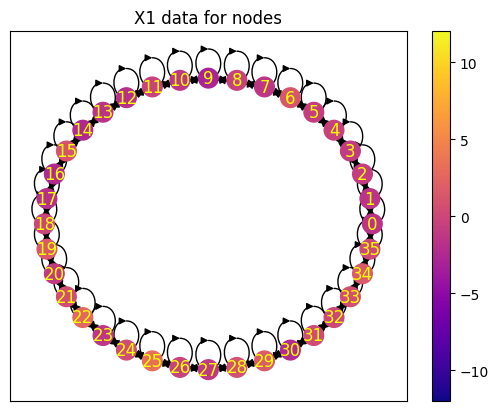

In [10]:
draw_jraph_graph_structure(graph_tuple_list[10])

visualize time series data

In [11]:
def plot_time_series_for_node(node):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle("sampled time series after reshaping", size=28)
    ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
                  size=20)
    ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node),
                  size=20)
    plt.xlabel('time (days)', size=16)

    ax0.plot(jnp.array([graph_tuple_list[i].nodes[node][0]
                        for i in range(200)]))
    ax1.plot(jnp.array([graph_tuple_list[i].nodes[node][1]
                        for i in range(200)]))


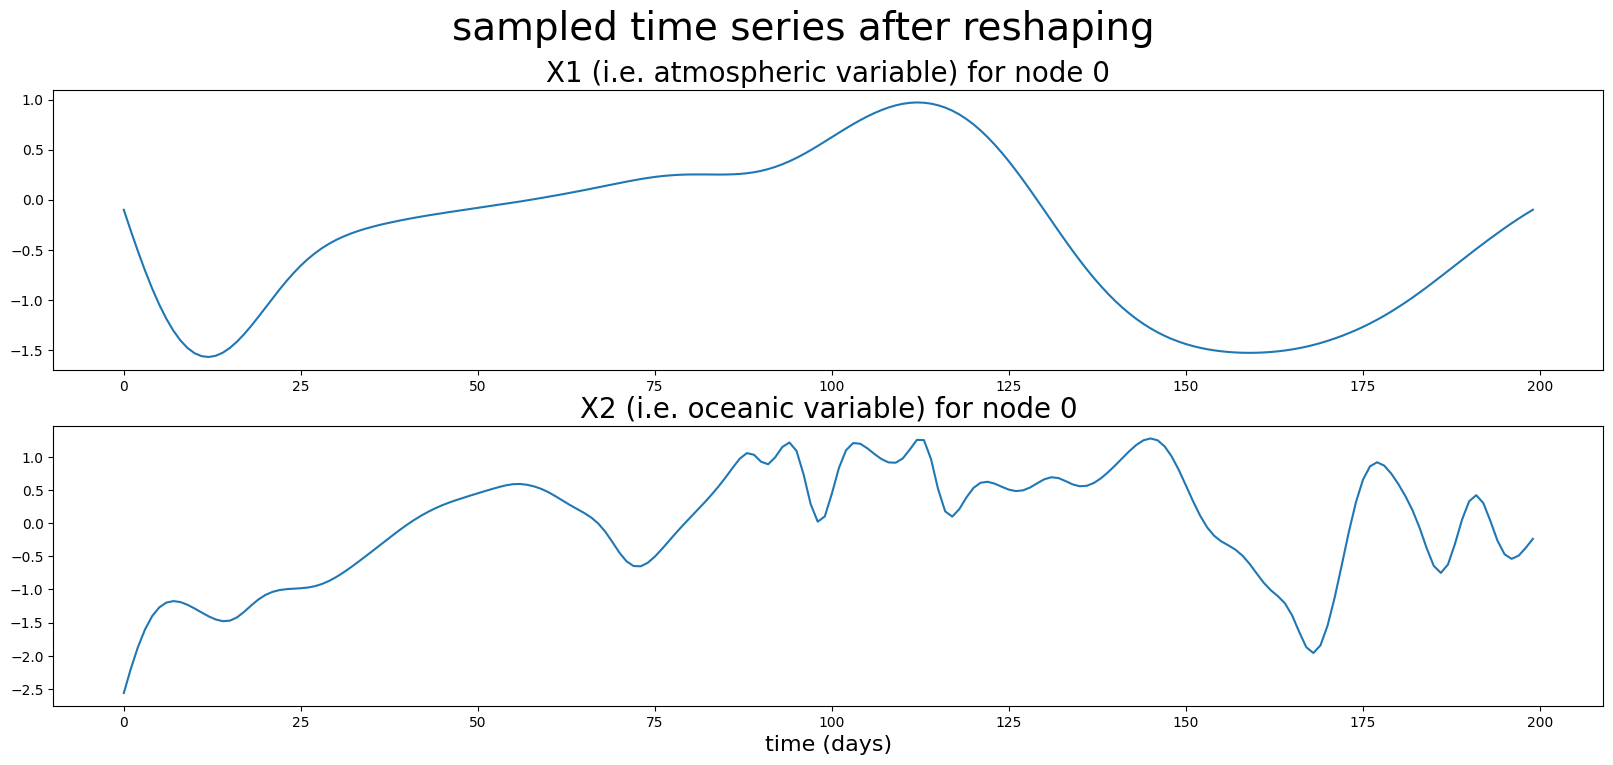

In [12]:
plot_time_series_for_node(node=0)

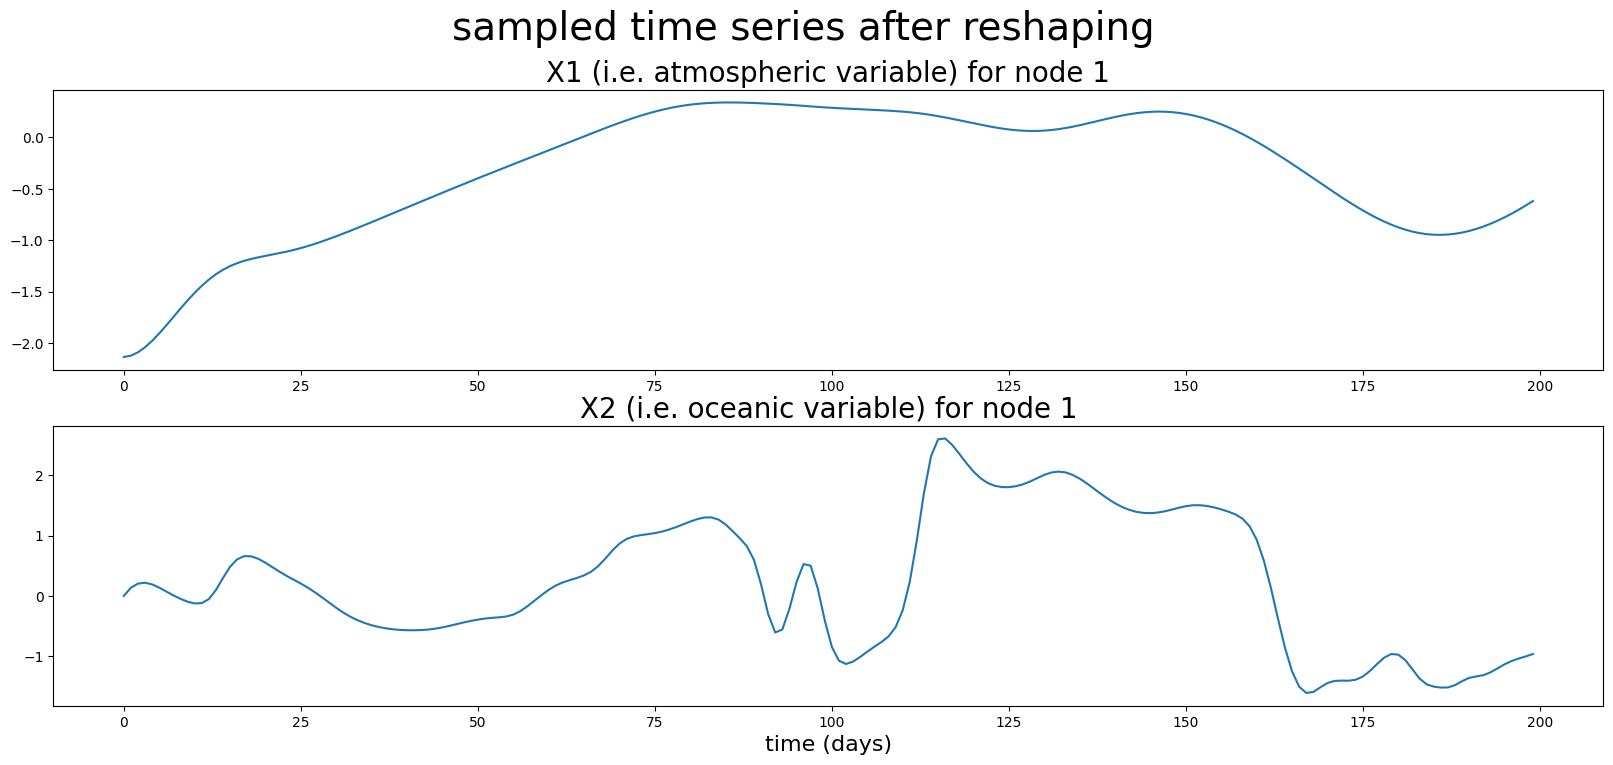

In [13]:
plot_time_series_for_node(node=1)

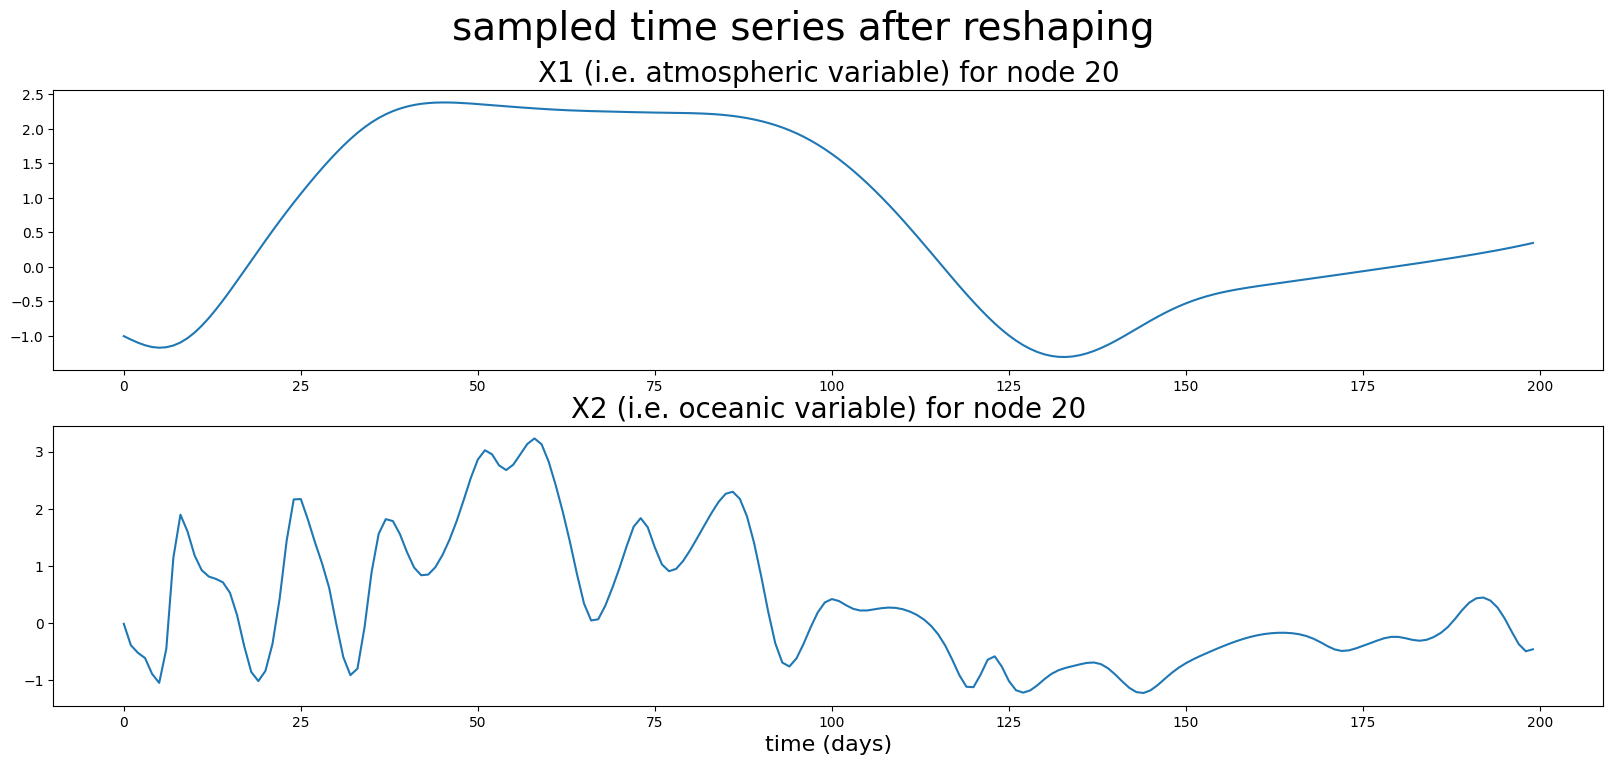

In [14]:
plot_time_series_for_node(node=20)

great, this matches the original lorenz data so we did the data handling correctly. 

### create model

In [361]:
# class MLPBlock(hk.Module):

#     def __init__(
#         self,
#         #  edge_mlp_features: Iterable[int],
#         #  node_mlp_features: Iterable[int],
#         #  graph_mlp_features: Iterable[int],
#         name: str = "MLPBlock"):
#         """ A function that creates a single GN block with MLP edge, node, and global models, and then passes input_graph through the model to transform it

#             Returns: a transformed graph

#             Args:
#                 input_graph:
#                 *_mlp_features (int list):
#         """
#         super(MLPBlock, self).__init__(name=name)
#         self._graph_net = jraph.GraphNetwork(update_node_fn=update_node_MLP_fn,
#                                              update_edge_fn=None,
#                                              update_global_fn=None)
#         # we have to use a lambda we want to return a function, not the module itself. it we try to return the module, we will get an error that the module must be initialized inside hk.transform

#     def __call__(self, input_graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
#         return self._graph_net(input_graph)


# we need to concat_args decorator because the GraphNetwork will pass in multiple arguments (e.g. edges + source features + etc etc)
# TODO: maybe turn this into a partial func? so then we can pass in custom
# output_sizes
@jraph.concatenated_args
def update_node_MLP_fn(x: jnp.ndarray) -> jnp.ndarray:
    mlp = hk.nets.MLP(output_sizes=[16, 2])
    return mlp(x)


@jraph.concatenated_args
def update_edge_MLP_fn(x: jnp.ndarray) -> jnp.ndarray:
    mlp = hk.nets.MLP(output_sizes=[16, 1])
    return mlp(x)


# should this be 0? or 1? or do we just get rid of this func?
# the jraph example notebook has a non-0 output size, interesting
@jraph.concatenated_args
def update_global_MLP_fn(x: jnp.ndarray) -> jnp.ndarray:
    mlp = hk.nets.MLP(output_sizes=[1])
    return mlp(x)


# def MLPBlock_fn(input_graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
#     net = MLPBlock()
#     return net(input_graph)


In [362]:
# we need to concat_args decorator because the GraphNetwork will pass in multiple arguments (e.g. edges + source features + etc etc)
# TODO: maybe turn this into a partial func? so then we can pass in custom
# output_sizes
@jraph.concatenated_args
def update_node_MLP_fn(x: jnp.ndarray) -> jnp.ndarray:
    mlp = hk.nets.MLP(output_sizes=[16, 2])
    return mlp(x)


def MLPBlock_fn(
    input_graph: jraph.GraphsTuple
    #     , edge_mlp_features: Iterable[int],
    #  node_mlp_features: Iterable[int],
    #  graph_mlp_features: Iterable[int]
) -> jraph.GraphsTuple:
    """ A function that creates a single GN block with MLP edge, node, and global models, and then passes input_graph through the model to transform it

        Returns: a transformed graph

        Args:
            input_graph:
            *_mlp_features (int list):
    """
    graph_net = jraph.GraphNetwork(update_node_fn=update_node_MLP_fn,
                                   update_edge_fn=update_edge_MLP_fn,
                                   update_global_fn=update_global_MLP_fn)
    # we have to use a lambda we want to return a function, not the module itself. it we try to return the module, we will get an error that the module must be initialized inside hk.transform

    return graph_net(input_graph)


In [366]:
class MLPGraphNetwork(hk.Module):
    """GraphNetwork consisting of a sequence of MLPBlocks."""

    def __init__(
        self,
        n_blocks: int,
        recurrent: bool,
        #  edge_mlp_features:Iterable[int],
        #  node_mlp_features:Iterable[int],
        #  graph_mlp_features:Iterable[int],
        name: str = "MLPGraphNetwork"):
        """ Initializes

            Args:
                n_blocks (int): number of MLP blocks
                recurrent (bool): whether or not to share weights btwn blocks
        """
        super(MLPGraphNetwork, self).__init__(name=name)
        self.n_blocks = n_blocks
        self.recurrent = recurrent

        if recurrent:
            raise NotImplementedError
            # self._network = MLPBlock(edge_mlp_features,
            #      node_mlp_features,
            #      graph_mlp_features)
        else:
            self._network = hk.Sequential([
                MLPBlock(
                    # edge_mlp_features,
                    #  node_mlp_features,
                    #  graph_mlp_features,
                    name=f'Block_{i}')
            ] for i in range(n_blocks))

    def __call__(self, input_graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        if self.recurrent:
            raise NotImplementedError
            # does recurrent need to keep track of internal states? shouldn't we need a gated unit or smth?
            # cause in this sense the ffw can be "recurrent" too e.g. if the core was 9 blocks long but in the rollout we just feed outputs back in to the core autoregressively
            x = inputs
            for _ in self.n_blocks:
                x = self._network(x)
            return x
        else:
            return self._network(input_graph)


def MLPGraphNetwork_fn(input_graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    # params taken from the graph_net physics demo notebook
    net = MLPGraphNetwork(
        n_blocks=9,
        recurrent=False,
        #  edge_mlp_features=[16,16],
        #  node_mlp_features=[16,16],
        #  graph_mlp_features=[16,16]
    )

    return net(input_graph)

In [367]:
ffw_network = hk.transform(MLPGraphNetwork_fn)
ffw_network

Transformed(init=<function without_state.<locals>.init_fn at 0x15747d820>, apply=<function without_state.<locals>.apply_fn at 0x15747d670>)

### create training utils

In [368]:
def get_data_windows(graph_tuple_list, n_rollout_steps):
    """ Get inputs and targets from a graph_tuple containing time series data
    
        Args: 
            graph_tuple_list: a list of GraphsTuple objects
            n_rollout_steps (int): number of steps for rollout output

        Returns:
            inputs, 1D list of length (timesteps - 2 - n_rollout_steps)
            targets, 2D list of size (timesteps - 2 - n_rollout_steps, n_rollout_steps)
    """
    inputs = []
    targets = []
    # TODO: maybe we should convert these to a pd dataframe?
    # this also seems quite space-inefficient

    orig_timesteps = len(graph_tuple_list)
    n_timesteps = orig_timesteps - 1 - n_rollout_steps

    print(orig_timesteps, n_timesteps)
    for i in range(n_timesteps):
        input_graph = graph_tuple_list[i]
        target_graphs = graph_tuple_list[i + 1:i + 1 + n_rollout_steps]
        inputs.append(input_graph)
        targets.append(target_graphs)

    # return np.concatenate(inputs, axis=0, dtype=object), np.concatenate(targets, axis=0, dtype=object)
    # return np.vstack(inputs), np.vstack(targets)
    return inputs, targets


In [369]:
def rollout(
        graph_tuple: jraph.GraphsTuple,
        model: jraph.GraphsTuple,  # is this right
        params,
        n_rollout_steps: int) -> Iterable[jraph.GraphsTuple]:
    """ Given a single sample of input data, apply the model n times to yield a 
        rollout of n predictions
    """
    pred_graphs = []
    x = graph_tuple

    # TODO: check if we need anything special for this for loop
    for i in range(n_rollout_steps):
        pred = model.apply(params, x)
        pred_graphs.append(pred)
        x = pred

    return pred_graphs

In [406]:
def compute_loss(
        params: hk.
    Params,  # we put params as the first arg since jax.value_and_grad by default differentiates wrt the first argument
        input_graph: jraph.GraphsTuple,
        target_graph: jraph.GraphsTuple,
        model: jraph.GraphsTuple):
    """ Calculates the loss from doing an n-step rollout (i.e. the average of all losses)
    """
    print('inside func')
    # pred_graphs = []
    x = input_graph

    # TODO: check if we need anything special for this for loop
    # for i in range(n_rollout_steps):
    print('before apply')
    pred = model.apply(params, x)
    print('after apply')

    err = pred.nodes - target_graph.nodes
    mse = jnp.mean(jnp.square(err))
    print('after calc loss')
    print(mse)
    return mse

In [418]:
def rollout_loss(input_graph: jraph.GraphsTuple,
                 target_graphs: Iterable[jraph.GraphsTuple],
                 model: jraph.GraphsTuple, params: hk.Params,
                 n_rollout_steps: int):
    """ Calculates the loss from doing an n-step rollout (i.e. the average of all losses)
    """
    print('in rollout_loss')
    pred_graphs = []
    x = input_graph

    # TODO: check if we need anything special for this for loop
    for i in range(n_rollout_steps):
        pred = model.apply(params, x)
        pred_graphs.append(pred)
        x = pred

    all_pred_attrs = jnp.array([pred.nodes for pred in pred_graphs])
    print(all_pred_attrs.shape)
    all_target_attrs = jnp.array([target.nodes for target in target_graphs])
    err = all_pred_attrs - all_target_attrs
    mse = jnp.mean(jnp.square(err))
    return mse, pred_graphs

In [408]:
def compute_loss_generic(x, target, model, params: hk.Params):
    """ Calculates the loss from doing an n-step rollout (i.e. the average of all losses)
    """

    # TODO: check if we need anything special for this for loop
    # for i in range(n_rollout_steps):
    pred = model.apply(params, x)

    err = pred - target
    mse = jnp.mean(jnp.square(err))
    return mse, pred

### training funcs

In [409]:
# Adapted from
# https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb
# which was adapted from
# https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def train(dataset: List[Dict[str, Any]], num_train_steps: int) -> hk.Params:
    """Training loop.
    
        Args:
            dataset: a list of dictionaries with the following keys:
                input_graphs: list containing jraph.GraphTuple graphs 
                target: single jraph.GraphTuple graph, x hours in the future 
    """

    # Transform impure `MLPGraphNetwork_fn` to pure functions with hk.transform.
    ffw_network = hk.without_apply_rng(hk.transform(MLPGraphNetwork_fn))
    # this has two functions, init and apply

    # Get a dummy graph and label to initialize the network.
    graph = dataset[0]['input_graph'][0]

    # Initialize the network.
    params = ffw_network.init(jax.random.PRNGKey(42), graph)
    # Initialize the optimizer.
    opt_init, opt_update = optax.adam(
        1e-4)  # these are two functions to init and apply
    opt_state = opt_init(params)

    preds = []

    compute_loss_fn = functools.partial(rollout_loss, net=ffw_network)
    # We jit the computation of our loss, since this is the main computation.
    # Using jax.jit means that we will use a single accelerator. If you want
    # to use more than 1 accelerator, use jax.pmap. More information can be
    # found in the jax documentation.
    compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn))

    for idx in range(num_train_steps):
        graph = dataset[idx % len(dataset)]['input_graph']
        label = dataset[idx % len(dataset)]['target']
        # Jax will re-jit your graphnet every time a new graph shape is encountered.
        # In the limit, this means a new compilation every training step, which
        # will result in *extremely* slow training. To prevent this, pad each
        # batch of graphs to the nearest power of two. Since jax maintains a cache
        # of compiled programs, the compilation cost is amortized.
        # graph = pad_graph_to_nearest_power_of_two(graph)

        # Since padding is implemented with pad_with_graphs, an extra graph has
        # been added to the batch, which means there should be an extra label.
        # label = jnp.concatenate([label, jnp.array([0])])

        (loss, acc), grad = compute_loss_fn(params, graph, label)
        updates, opt_state = opt_update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        if idx % 50 == 0:
            print(f'step: {idx}, loss: {loss}, acc: {acc}')
    print('Training finished')
    return params


##### train steps one at a time before putting it in a func

In [410]:
print_graph_fts(graph_tuple_list[0])

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
globals: [[1]]


In [419]:
ffw_network = hk.without_apply_rng(hk.transform(MLPBlock_fn))
# this has two functions, init and apply

# Get a dummy graph and label to initialize the network.
graph = graph_tuple_list[0]

# Initialize the network.
params = ffw_network.init(jax.random.PRNGKey(42), graph)
# Initialize the optimizer.
opt_init, opt_update = optax.adam(
    1e-4)  # these are two functions to init and apply
opt_state = opt_init(params)

mse, pred_graphs = rollout_loss(input_graph=graph_tuple_list[0],
                                target_graphs=graph_tuple_list[1:3],
                                model=ffw_network,
                                params=params,
                                n_rollout_steps=2)
print(mse)
# pred_graphs

in rollout_loss
(2, 36, 2)
6.213643


### train